In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import neurax as nx
from neurax.channels import HHChannel
from neurax.synapses import GlutamateSynapse

### Setup

In [4]:
# Number of segments per branch.
nseg_per_branch = 8

# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [5]:
time_vec = jnp.arange(0.0, t_max+dt, dt)

### Define stimuli and recordings

In [6]:
recs = [nx.Recording(cell_ind, 1, 0.0) for cell_ind in range(5)]
stims = [
    nx.Stimulus(stim_ind, 1, 0.0, current=nx.step_current(i_delay, i_dur, i_amp, time_vec)) for stim_ind in range(2)
]

### Let's define a network

In [7]:
comp = nx.Compartment().initialize()
branch = nx.Branch([comp for _ in range(nseg_per_branch)]).initialize()
cell = nx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 0, 1, 1])).initialize()

In [8]:
_ = np.random.seed(0)
conn_builder = nx.ConnectivityBuilder([cell.total_nbranches for _ in range(5)])
connectivities = [nx.Connectivity(GlutamateSynapse(), conn_builder.fc(np.arange(0, 2), np.arange(2, 5)))]

In [9]:
network = nx.Network([cell for _ in range(5)], connectivities).initialize()

### Setting parameters

Parameters can be set globally or locally. Without any channels, the following parameters can be set: `radius`, `length`, `axial_resistivity`. To set the radius of every compartment in the entire network, do:

In [10]:
network.set_params("radius", 0.5)

To change the `length` of all compartment in the first cell, do:

In [11]:
network.cell(0).set_params("length", 12.0)

### Add mechanisms and change their parameters

In [12]:
network.cell(0).branch(0).insert(HHChannel())

If you added channels in your compartments, you can also edit their parameters in the same way. For example, to set the sodium conductance of the first compartment of the second branch of the first cell, do:

In [13]:
network.cell(0).branch(0).comp(0).set_params("gNa", 0.2)

### Setting synaptic parameters

In the same way, parameters of synapses can be set:

In [15]:
network.set_params("gS", 0.2)

### Setting the initial state

In the exact same way, you can also set the initial state of any compartment:

In [16]:
network.cell(0).branch(0).set_states("m", 0.3)

### Inspecting the parameters and states

You can also inspect parameters and states in the same way. Either for individual states or parameters:

In [17]:
network.cell(0).branch(0).comp(1).get_states("m")

Array([0.3], dtype=float64, weak_type=True)

or for all parameters/states:

In [18]:
network.show("HHChannel")

,comp_index,branch_index,cell_index,gNa,gK,gLeak,m,h,n
0,0,0,0,0.12,0.036,0.0003,0.3,0.2,0.2
1,1,0,0,0.12,0.036,0.0003,0.3,0.2,0.2
2,2,0,0,0.12,0.036,0.0003,0.3,0.2,0.2
3,3,0,0,0.12,0.036,0.0003,0.3,0.2,0.2
4,4,0,0,0.12,0.036,0.0003,0.3,0.2,0.2
5,5,0,0,0.12,0.036,0.0003,0.3,0.2,0.2
6,6,0,0,0.12,0.036,0.0003,0.3,0.2,0.2
7,7,0,0,0.20,0.036,0.0003,0.3,0.2,0.2


### Running the simulation with the new parameters

In [19]:
s = nx.integrate(network, stimuli=stims, recordings=recs, delta_t=dt)

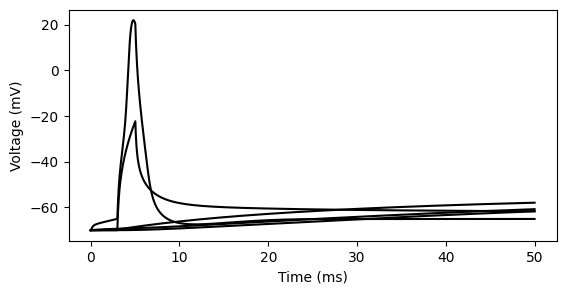

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
for i in range(len(recs)):
    _ = ax.plot(time_vec, s[i][:-1], c="k")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV)")
plt.show()